### This is a notebook to format your data for segmentation, run the images through the cloud instance of Mesmer, and then extract marker counts and morphological information from all the cells in your images

In [1]:
import threading
threading.activeCount()

8

In [2]:
import cProfile as profile
import pstats

In [3]:
# import required packages
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import xarray as xr
from alpineer import io_utils, load_utils, image_utils

from ark.segmentation import marker_quantification, segmentation_utils
from ark.utils import (deepcell_service_utils, example_dataset,
                       plot_utils)

from deepcell.applications import Mesmer
from deepcell.datasets import multiplex_tissue
from pathlib import Path

from tensorflow.keras.models import load_model
from deepcell.utils.plot_utils import make_outline_overlay

from deepcell.utils.plot_utils import create_rgb_image
from matplotlib import pyplot as plt
import pathlib
from tqdm.notebook import tqdm
from deepcell.utils.io_utils import save_model_output
import gc
import pandas as pd

## 0: Set root directory and download example dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change `base_dir` to point to your own sub-directory within the data folder.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook.

In [4]:
# set up the ../data/external/celldive_data/base directory
base_dir = "../data/external/dataset_1"

If you would like to test the features in Ark with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

If you are using your own data, skip the cell below.

* `overwrite_existing`: If set to `False`, it will not overwrite existing data in the `data/example_dataset`. Recommended leaving as `True` if you are doing a clean run of the `ark` pipeline using this dataset from the start. If you already have the dataset downloaded, set to `False`.

## 1: set file paths and parameters

### All data, images, files, etc. must be placed in the 'data' directory, and referenced via '../data/path_to_your_data'

If you're interested in directly interfacing with Google Drive, consult the documentation [here](https://ark-analysis.readthedocs.io/en/latest/_rtd/google_docs_usage.html).

In [5]:
# set up file paths
ome_tiff_dir = os.path.join(base_dir, "ome_tiff")
ome_tiff_out_dir = os.path.join(base_dir, "ome_tiff_out")
tiff_dir = os.path.join(base_dir, "image_data")
cell_table_dir = os.path.join(base_dir, "segmentation/cell_table_raw")
cell_table_dir_qc = os.path.join(base_dir, "segmentation/cell_table")
deepcell_input_dir = os.path.join(base_dir, "segmentation/deepcell_input")
deepcell_output_dir = os.path.join(base_dir, "segmentation/deepcell_output")
deepcell_visualization_dir = os.path.join(base_dir, "segmentation/deepcell_visualization")

In [6]:
# create directories if do not exist
for directory in [tiff_dir, cell_table_dir, cell_table_dir_qc, deepcell_input_dir, deepcell_output_dir, deepcell_visualization_dir, ome_tiff_out_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [7]:
# validate paths
io_utils.validate_paths([ome_tiff_dir,
                         base_dir,
                         tiff_dir,
                         deepcell_input_dir,
                         deepcell_output_dir,
                         cell_table_dir,
                         cell_table_dir_qc,
                         deepcell_visualization_dir,
                         ome_tiff_out_dir
                         ])

### Extract OME TIFF

In [8]:
# Gather all the OME-TIFFs
ome_dir = pathlib.Path(ome_tiff_dir)
ome_tiffs = list(ome_dir.glob("*.ome.[tif tiff]*"))

In [9]:
os.listdir(ome_tiff_dir)

['ATAPOX166R-3.ome.tiff']

In [10]:
# # Convert all the OME-TIFFs to Single Channel TIFFs
for ome_tiff in tqdm(ome_tiffs):
    load_utils.ome_to_fov(ome_tiff, data_dir=tiff_dir)

  0%|          | 0/1 [00:00<?, ?it/s]

### Compute and filter fov paths

In [11]:
# get all fovs in the folder...
fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = [fovs[j] for j in [0]]

In [12]:
fovs

['ATAPOX166R-3']

### Load images into notebook, process, and save as Mesmer compatable input

In [13]:
io_utils.remove_file_extensions(io_utils.list_files(os.path.join(tiff_dir, fovs[0])))

['C1Q',
 'CCL19',
 'CCR6',
 'CCR7',
 'CD11C',
 'CD20',
 'CD208',
 'CD3',
 'CD31',
 'CD38',
 'CD4',
 'CD40',
 'CD40L',
 'CD45',
 'CD66B',
 'CD68',
 'CD8A',
 'CK8',
 'CTLA4',
 'CXCR3',
 'CXCR5',
 'DAPI_FINAL',
 'DAPI_INIT',
 'FAP',
 'FOXP3',
 'HLAA',
 'HLADR',
 'IGA',
 'IGD',
 'IGG',
 'IL1B',
 'IL23P19',
 'MCAM',
 'MPO',
 'PD1',
 'PDGFRA',
 'PDPN',
 'RORGT',
 'THY1',
 'TIGIT',
 'TRYPTASE',
 'VIM']

In [14]:
# NOTE: at least one of nucs and mems must not be None
# nuclear channel name(s) (or nucs = None)
nucs = ['DAPI_FINAL']

# membrane channel name(s) (or mems = None)
mems = ['HLAA', 'HLADR', 'CD68', 'CK8', 'CD3', 'CD45', 'VIM'] # mathilde

In [15]:
# generate and save deepcell input tiffs
# set img_sub_folder param to None if the image files in tiff_dir are not in a separate sub folder 
deepcell_service_utils.generate_deepcell_input(
    deepcell_input_dir,
    tiff_dir,
    nucs,
    mems,
    fovs,
    img_sub_folder=None
)

### Prepare for local Mesmer analysis

In [16]:
fov0 = load_utils.load_imgs_from_dir(deepcell_input_dir, xr_channel_names=["nuclear", "membran"])

## 2: Upload files to Deepcell and download results

Deepcell input images will be zipped into a single file, uploaded to [deepcell.org](https://deepcell.org),

and the output will be downloaded to the deepcell output directory.

In [17]:
# Mesmer was trained on data acquired at 20X resolution. If your image data was acquired at a different resolution, you will get the best performance by rescaling. The rescale factor will increase or decrease the image resolution by the value you provide. For example, if you data was acquired at 10X, use a `rescale_factor` of 2. If your data was acquired at 60X resolution, use a `rescale_factor` of 0.33.
rescale_factor = 1.0

### Run deepcell locally

In [18]:
keras_model = load_model(Path("/.keras/models/MultiplexSegmentation") )
app = Mesmer(model=keras_model)

2023-06-08 11:47:14.673327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-08 11:47:14.691325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-08 11:47:14.693007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-08 11:47:14.696190: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the app

In [19]:
def calc_n_tiles(dim, tile_size, overlap=0):
    n_tiles = (dim - overlap) / (tile_size - overlap)
    return(n_tiles)

def create_overlapping_tiles1(dim1,  max_tile_size, overlap):
    tile_sizes = [*range(overlap+1,max_tile_size+1)]
    tile_sizes.reverse()
    
    res = 0
    
    for x in tile_sizes:
        if ((calc_n_tiles(dim1, x, overlap)).is_integer()):
        # if (calc_n_tiles(dimx, x, overlap)).is_integer():
            res = x
            break
            
    if res == 0:
        raise Exception('could not find an appropriate tile size')
    else:
        return(res)


def create_overlapping_tiles2(dim1, dim2,  max_tile_size, overlap):
    tile_sizes = [*range(overlap+1,max_tile_size+1)]
    tile_sizes.reverse()
    
    res = 0
    
    for x in tile_sizes:
        if ((calc_n_tiles(dim1, x, overlap)).is_integer()) and ((calc_n_tiles(dim2, x, overlap)).is_integer()):
        # if (calc_n_tiles(dimx, x, overlap)).is_integer():
            res = x
            break
            
    if res == 0:
        raise Exception('could not find an appropriate tile size')
    else:
        return(res)
    
    
def create_deepcell_overlapping_tiles(dim1, dim2,  max_tile_size, overlap, accepted_ratio = 2.0):
    
    
    return(res1, res2)
    

def remove_boundary_mask(arr, boundary, boundary_sides, dummy_var):
    boundary_ids = list()
    for boundary_side in boundary_sides:
        if "t" in boundary_side:
            boundary_mask = arr[0:boundary, :]
            _boundary_ids = np.unique(boundary_mask)
            boundary_ids = [j for i in [boundary_ids, _boundary_ids] for j in i]
            
        elif "b" in boundary_side:
            boundary_mask = arr[-boundary:, :]
            _boundary_ids = np.unique(boundary_mask)
            boundary_ids = [j for i in [boundary_ids, _boundary_ids] for j in i]
            
        elif "r" in boundary_side:
            boundary_mask = arr[:, -boundary:]
            _boundary_ids = np.unique(boundary_mask)
            boundary_ids = [j for i in [boundary_ids, _boundary_ids] for j in i]

        elif "l" in boundary_side:
            boundary_mask = arr[:, 0:boundary]
            _boundary_ids = np.unique(boundary_mask)
            boundary_ids = [j for i in [boundary_ids, _boundary_ids] for j in i]
    
    boundary_ids = np.unique(boundary_ids)
    boundary_ids= [i for i in boundary_ids if i != 0]
    # cleaned_arr = np.copy(arr)
    cleaned_arr = np.where(np.isin(arr, boundary_ids), dummy_var, arr)
    return(cleaned_arr)
    

def determine_boundaries(img, r0,r1,c0,c1):
    boundaries = list()
    if c0 != 0:
        boundaries.append("l")
    if c1 != img.shape[2]:
        boundaries.append("r")
    if r0 != 0:
        boundaries.append("t")
    if r1 != img.shape[1]:
        boundaries.append("b")
    
    return(boundaries)

def tiled_segmentation(img, start_row, start_col, stop_row, stop_col, step_size_row, step_size_col, dummy_var, cutoff=2, compartment='whole-cell'):
    if compartment in ["whole-cell", "nuclear"]:
        mask_array = np.expand_dims(np.zeros_like(img, dtype=int)[:,:,:,0], 3)
    elif compartment == "both":
        mask_array = np.zeros_like(img, dtype=int)
    
    max_current_cell_id = np.zeros(mask_array.shape[3]) 
    
    for row in range(start_row, stop_row, step_size_row):
        for col in range(start_col, stop_col, step_size_col):
            r0, r1 = np.maximum(row, 0), np.minimum(row + step_size_row, img.shape[1])
            c0, c1 = np.maximum(col, 0), np.minimum(col + step_size_col, img.shape[2])
                        
            boundaries = determine_boundaries(img, r0,r1,c0,c1)
            
            if np.max(img[:,:,:,:]) < cutoff:
                tmp_segmentation = np.zeros_like(mask_array, dtype=int)[:, r0:r1, c0:c1,:]
            else:
                tmp_segmentation = app.predict(img[:, r0:r1, c0:c1,:], compartment=compartment)

                for j in range(tmp_segmentation.shape[3]):
                    tmp_segmentation[0,:,:,j] = remove_boundary_mask(tmp_segmentation[0,:,:,j], cutoff, boundaries, dummy_var)

                    tmp_segmentation[0,:,:,j] = make_cell_mask_unique_fast(tmp_segmentation[0,:,:,j], dummy_var, max_current_cell_id[j])
                    max_current_cell_id[j] = np.max(tmp_segmentation[0,:,:,j])
                
            ### remove overlapping ids
            mask_array[0, r0:r1, c0:c1, j] = tmp_segmentation[0,:,:,j]
    gc.collect()
    return(mask_array)

def tiled_segmentation_overlap(img, start_row, start_col, stop_row, stop_col, step_size_row, step_size_col, dummy_var, cutoff=2, compartment='whole-cell'):
    if compartment in ["whole-cell", "nuclear"]:
        mask_array = np.expand_dims(np.zeros_like(img, dtype=int)[:,:,:,0], 3)
    elif compartment == "both":
        mask_array = np.zeros_like(img, dtype=int)
    
    max_current_cell_id = np.zeros(mask_array.shape[3]) 
    
    for row in range(start_row, stop_row, step_size_row):
        for col in range(start_col, stop_col, step_size_col):
            r0, r1 = np.maximum(row, 0), np.minimum(row + step_size_row, img.shape[1])
            c0, c1 = np.maximum(col, 0), np.minimum(col + step_size_col, img.shape[2])
                        
            boundaries = determine_boundaries(img, r0,r1,c0,c1)
            
            if np.max(img[:,:,:,:]) < cutoff:
                tmp_segmentation = np.zeros_like(mask_array, dtype=int)[:, r0:r1, c0:c1,:]
            else:
                tmp_segmentation = app.predict(img[:, r0:r1, c0:c1,:], compartment=compartment)

                for j in range(tmp_segmentation.shape[3]):
                    tmp_segmentation[0,:,:,j] = remove_boundary_mask(tmp_segmentation[0,:,:,j], cutoff, boundaries, dummy_var)
#                   embed small mask in bigger mask and combine them in overall segmentation
                    tmp_segmentation[0,:,:,j] = make_cell_mask_unique_fast(tmp_segmentation[0,:,:,j], dummy_var, max_current_cell_id[j])
                    max_current_cell_id[j] = np.max(tmp_segmentation[0,:,:,j])
                
            ### remove overlapping ids
            mask_array[0, r0:r1, c0:c1, j] = tmp_segmentation[0,:,:,j]
    gc.collect()
    return(mask_array)

def make_cell_mask_unique(input_array, dummy_var, offset):
    cell_ids = np.unique(input_array)
    cell_ids = cell_ids[~np.isin(cell_ids, [dummy_var, 0])]
    
    transdict = {cell_ids[n] : n + offset + 1 for n in range(0,cell_ids.shape[0])}
    transdict.update({0 : 0})
    transdict.update({dummy_var : dummy_var})
        
    k = np.array(list(transdict.keys()))
    v = np.array(list(transdict.values()))

    out = np.zeros_like(input_array)
    for key,val in zip(k,v):
        out[input_array==key] = val

    return(out)

def getval_array(d):
    # based on https://stackoverflow.com/a/46870227
    v = np.array(list(d.values()))
    k = np.array(list(d.keys()))
    maxv = k.max()
    minv = k.min()
    n = maxv - minv + 1
    val = np.empty(n,dtype=v.dtype)
    val[k] = v
    return val


def make_cell_mask_unique_fast(input_array, dummy_var, offset):
    cell_ids = np.unique(input_array)
    cell_ids = cell_ids[~np.isin(cell_ids, [dummy_var, 0])]
    
    transdict = {cell_ids[n] : n + offset + 1 for n in range(0,cell_ids.shape[0])}
    transdict.update({0 : 0})
    transdict.update({dummy_var : dummy_var})
    
    val_arr = getval_array(transdict)
    out = val_arr[input_array]
    
    return(out)


def _combine_overlapping_masks(mask_x, mask_y, dummy_var):
    max_cell_id_x = np.max(mask_x)

    mask_out_x = make_cell_mask_unique_fast(mask_x, dummy_var, 0)
    mask_out_y = make_cell_mask_unique_fast(mask_y, dummy_var, max_cell_id_x)

    # mask_xy = np.copy(mask_x)
    mask_x[np.isin(mask_out_x, dummy_var)] = mask_out_y[np.isin(mask_out_x, dummy_var)]
    gc.collect()
    return(mask_x)

def combine_overlapping_mask(mask1, mask2, mask3, mask4, dummy_var):
    
    mask3_1 = _combine_overlapping_masks(mask3, mask4, dummy_var)
    mask2_1 = _combine_overlapping_masks(mask2, mask3_1, dummy_var)
    mask_final = _combine_overlapping_masks(mask1, mask2_1, dummy_var)

    return(mask_final)

def predict_tiled(img, tile_size, dummy_var, overlap=0, cutoff=2, infer_gaps = True, compartment='whole-cell'):
    #   ensure the image has 4 dimensions to start with and that the last one is 2 dims
    if len(img.shape) != 4:
        raise ValueError(f"Image data must be 4D, got image of shape {img.shape}")
    if img.shape[3] != 2:
        raise ValueError(f"Each FOV/slide must have 2 channels, the image has {img.shape[3]} channels")
    
    #   iterate over the first dimension
    for fov_idx in range(img.shape[0]):
        fov = img[[fov_idx], ...]
      
        step_size_row = tile_size[0] #create_overlapping_tiles1(fov.shape[1], max_tiled, overlap)
        step_size_col = tile_size[1] #create_overlapping_tiles1(fov.shape[2], max_tiled, overlap)

        print("The tile size chosen is: " + str(step_size_row) +"px X " + str(step_size_col) + "px")    

        start_row1, start_col1, stop_row1, stop_col1 = 0, 0, fov.shape[1], fov.shape[2]
        
        if infer_gaps:
            start_row2, start_col2, stop_row2, stop_col2 = 0-int(step_size_row/2), 0-int(step_size_col/2), fov.shape[1]+int(step_size_row/2), fov.shape[2]+int(step_size_col/2) 
            start_row3, start_col3, stop_row3, stop_col3 = 0, 0-int(step_size_col/2), fov.shape[1], fov.shape[2]+int(step_size_col/2)
            start_row4, start_col4, stop_row4, stop_col4 = 0-int(step_size_row/2), 0, fov.shape[1]+int(step_size_row/2), fov.shape[2]
            mask1 = tiled_segmentation(fov, start_row1, start_col1, stop_row1, stop_col1, step_size_row, step_size_col, dummy_var, cutoff, compartment)
            mask2 = tiled_segmentation(fov, start_row2, start_col2, stop_row2, stop_col2, step_size_row, step_size_col, dummy_var, cutoff, compartment)
            mask3 = tiled_segmentation(fov, start_row3, start_col3, stop_row3, stop_col3, step_size_row, step_size_col, dummy_var, cutoff, compartment)
            mask4 = tiled_segmentation(fov, start_row4, start_col4, stop_row4, stop_col4, step_size_row, step_size_col, dummy_var, cutoff, compartment)

            _mask = combine_overlapping_mask(mask1, mask2, mask3, mask4, dummy_var)
        else:
            _mask = tiled_segmentation(fov, start_row1, start_col1, stop_row1, stop_col1, step_size_row, step_size_col, dummy_var, cutoff, compartment)
            _mask[np.isin(_mask, [-99])] = 0

        for j in range(_mask.shape[3]):
            _mask[:,:,:,j] = make_cell_mask_unique_fast(_mask[:,:,:,j], -99, 0)
        
        if fov_idx == 0:
            if img.shape[0] == 1:
                return(_mask)
            else:
                mask = np.copy(_mask)
        else:
            mask = np.concatenate([mask, _mask], axis=0)
        
        gc.collect()
        
    return(mask)

In [20]:
def func_test_steps(fov, step_size_row, step_size_col, mask = 1):
        if mask == 1:
            start_row, start_col, stop_row, stop_col = 0, 0, fov.shape[1], fov.shape[2]
        elif mask == 2:
            start_row, start_col, stop_row, stop_col = 0-int(step_size_row/2), 0-int(step_size_col/2), fov.shape[1]+int(step_size_row/2), fov.shape[2]+int(step_size_col/2) 
        elif mask == 3:
            start_row, start_col, stop_row, stop_col = 0, 0-int(step_size_col/2), fov.shape[1], fov.shape[2]+int(step_size_col/2)
        elif mask == 4:
            start_row, start_col, stop_row, stop_col = 0-int(step_size_row/2), 0, fov.shape[1]+int(step_size_row/2), fov.shape[2]

        for row in range(start_row, stop_row, step_size_row):
            for col in range(start_col, stop_col, step_size_col):
                r0, r1 = np.maximum(row, 0), np.minimum(row + step_size_row, fov.shape[1])
                c0, c1 = np.maximum(col, 0), np.minimum(col + step_size_col, fov.shape[2])

                print(r0, r1, c0, c1)

In [21]:
# test_img = np.zeros((1,6526, 3776, 2))

In [22]:
# tst_arr= np.random.randint(1,2000,(2000, 2000))
# tst_arr[2,2] = -99
# tst_arr[9, 3] = 0

In [23]:
# tst_arr.shape

In [24]:
# a = np.array([[  3,   0,   2,  -1],
#               [  1, 255,   -99,   2],
#               [  0,   3,   2,   2]])
# d = {0: 1, 1: 2, 2: 7, 3: 4, -1: 0, 255: 0, -99: -99}
# val_arr = getval_array(d)
# out = val_arr[a]
# out

In [25]:
# d_cell_ids = np.unique(tst_arr)
# d_cell_ids = d_cell_ids[~np.isin(d_cell_ids, [-99, 0])]

# d_cell_ids
    
# transdict = {d_cell_ids[n] : n + 5 + 1 for n in range(0,d_cell_ids.shape[0])}
# transdict.update({0 : 0})
# transdict.update({-99 : -99})
# transdict
# # d = 
# val_arr = getval_array(transdict)
# out = val_arr[tst_arr]
# # out

In [26]:
# b = np.array([[8,1,7], [4,3,9], [5,2,6]])
# b.shape

In [27]:
# profile.run("make_cell_mask_unique(tst_arr, -99, 22500)")

In [28]:
# profile.run("make_cell_mask_unique_searchsorted(tst_arr, -99, 22500)")

In [29]:
# (make_cell_mask_unique(tst_arr, -99, 50) == make_cell_mask_unique_searchsorted(tst_arr, -99, 50)).all()

In [30]:
# make_cell_mask_unique(tst_arr, -99, 50)

In [31]:
# make_cell_mask_unique_searchsorted(tst_arr, -99, 50)

In [32]:
# prof_van = profile.Profile()
# prof_van.enable()
# segmentation_predictions_whole = app.predict(fov0, image_mpp=0.5, compartment='whole-cell')
# prof_van.disable()

In [33]:
# stats_van = pstats.Stats(prof_van).strip_dirs().sort_stats("cumtime")
# stats_van.print_stats(10)

In [ ]:
# segmentation_predictions_whole_no_gaps = predict_tiled(fov0, 2000, -99, infer_gaps=True, compartment="whole-cell")

In [34]:
prof = profile.Profile()
prof.enable()
segmentation_predictions_whole_gaps = predict_tiled(fov0, [6526, 3776], -99, cutoff=2, infer_gaps=False, compartment="whole-cell")
prof.disable()

The tile size chosen is: 6526px X 3776px


2023-06-08 11:48:47.731935: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [35]:
stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
stats.print_stats(10)

         34721212 function calls (33198607 primitive calls) in 260.598 seconds

   Ordered by: cumulative time
   List reduced from 2720 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000  260.613  130.306 interactiveshell.py:3472(run_code)
      4/2    0.000    0.000  260.613  130.306 {built-in method builtins.exec}
        1    0.001    0.001  260.613  260.613 1599555615.py:3(<module>)
        1    0.270    0.270  260.612  260.612 3269271859.py:214(predict_tiled)
        1    0.378    0.378  256.904  256.904 3269271859.py:90(tiled_segmentation)
        4    0.012    0.003  243.068   60.767 mesmer.py:234(predict)
        4    0.022    0.005  243.055   60.764 application.py:393(_predict_segmentation)
        4    0.000    0.000  126.766   31.692 application.py:199(_postprocess)
        4    0.018    0.004  126.766   31.691 mesmer.py:102(mesmer_postprocess)
        4    0.215    0.054  126.748   31.687 deep_

In [36]:
# segmentation_predictions = np.asarray(load_utils.load_imgs_from_dir(deepcell_output_dir))

### We can then save the segmented mask overlaid on the imaging data

In [37]:
# create rgb overlay of image data for visualization
rgb_images = create_rgb_image(np.asarray(fov0[:,:,:,[0]]), channel_colors=['blue'])

In [38]:
# overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions_whole)
# overlay_data_tile_pipeline_gaps = make_outline_overlay(rgb_data=rgb_images, predictions=pipeline_mask_gaps)
overlay_data_tile_pipeline_no_gaps = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions_whole_gaps)

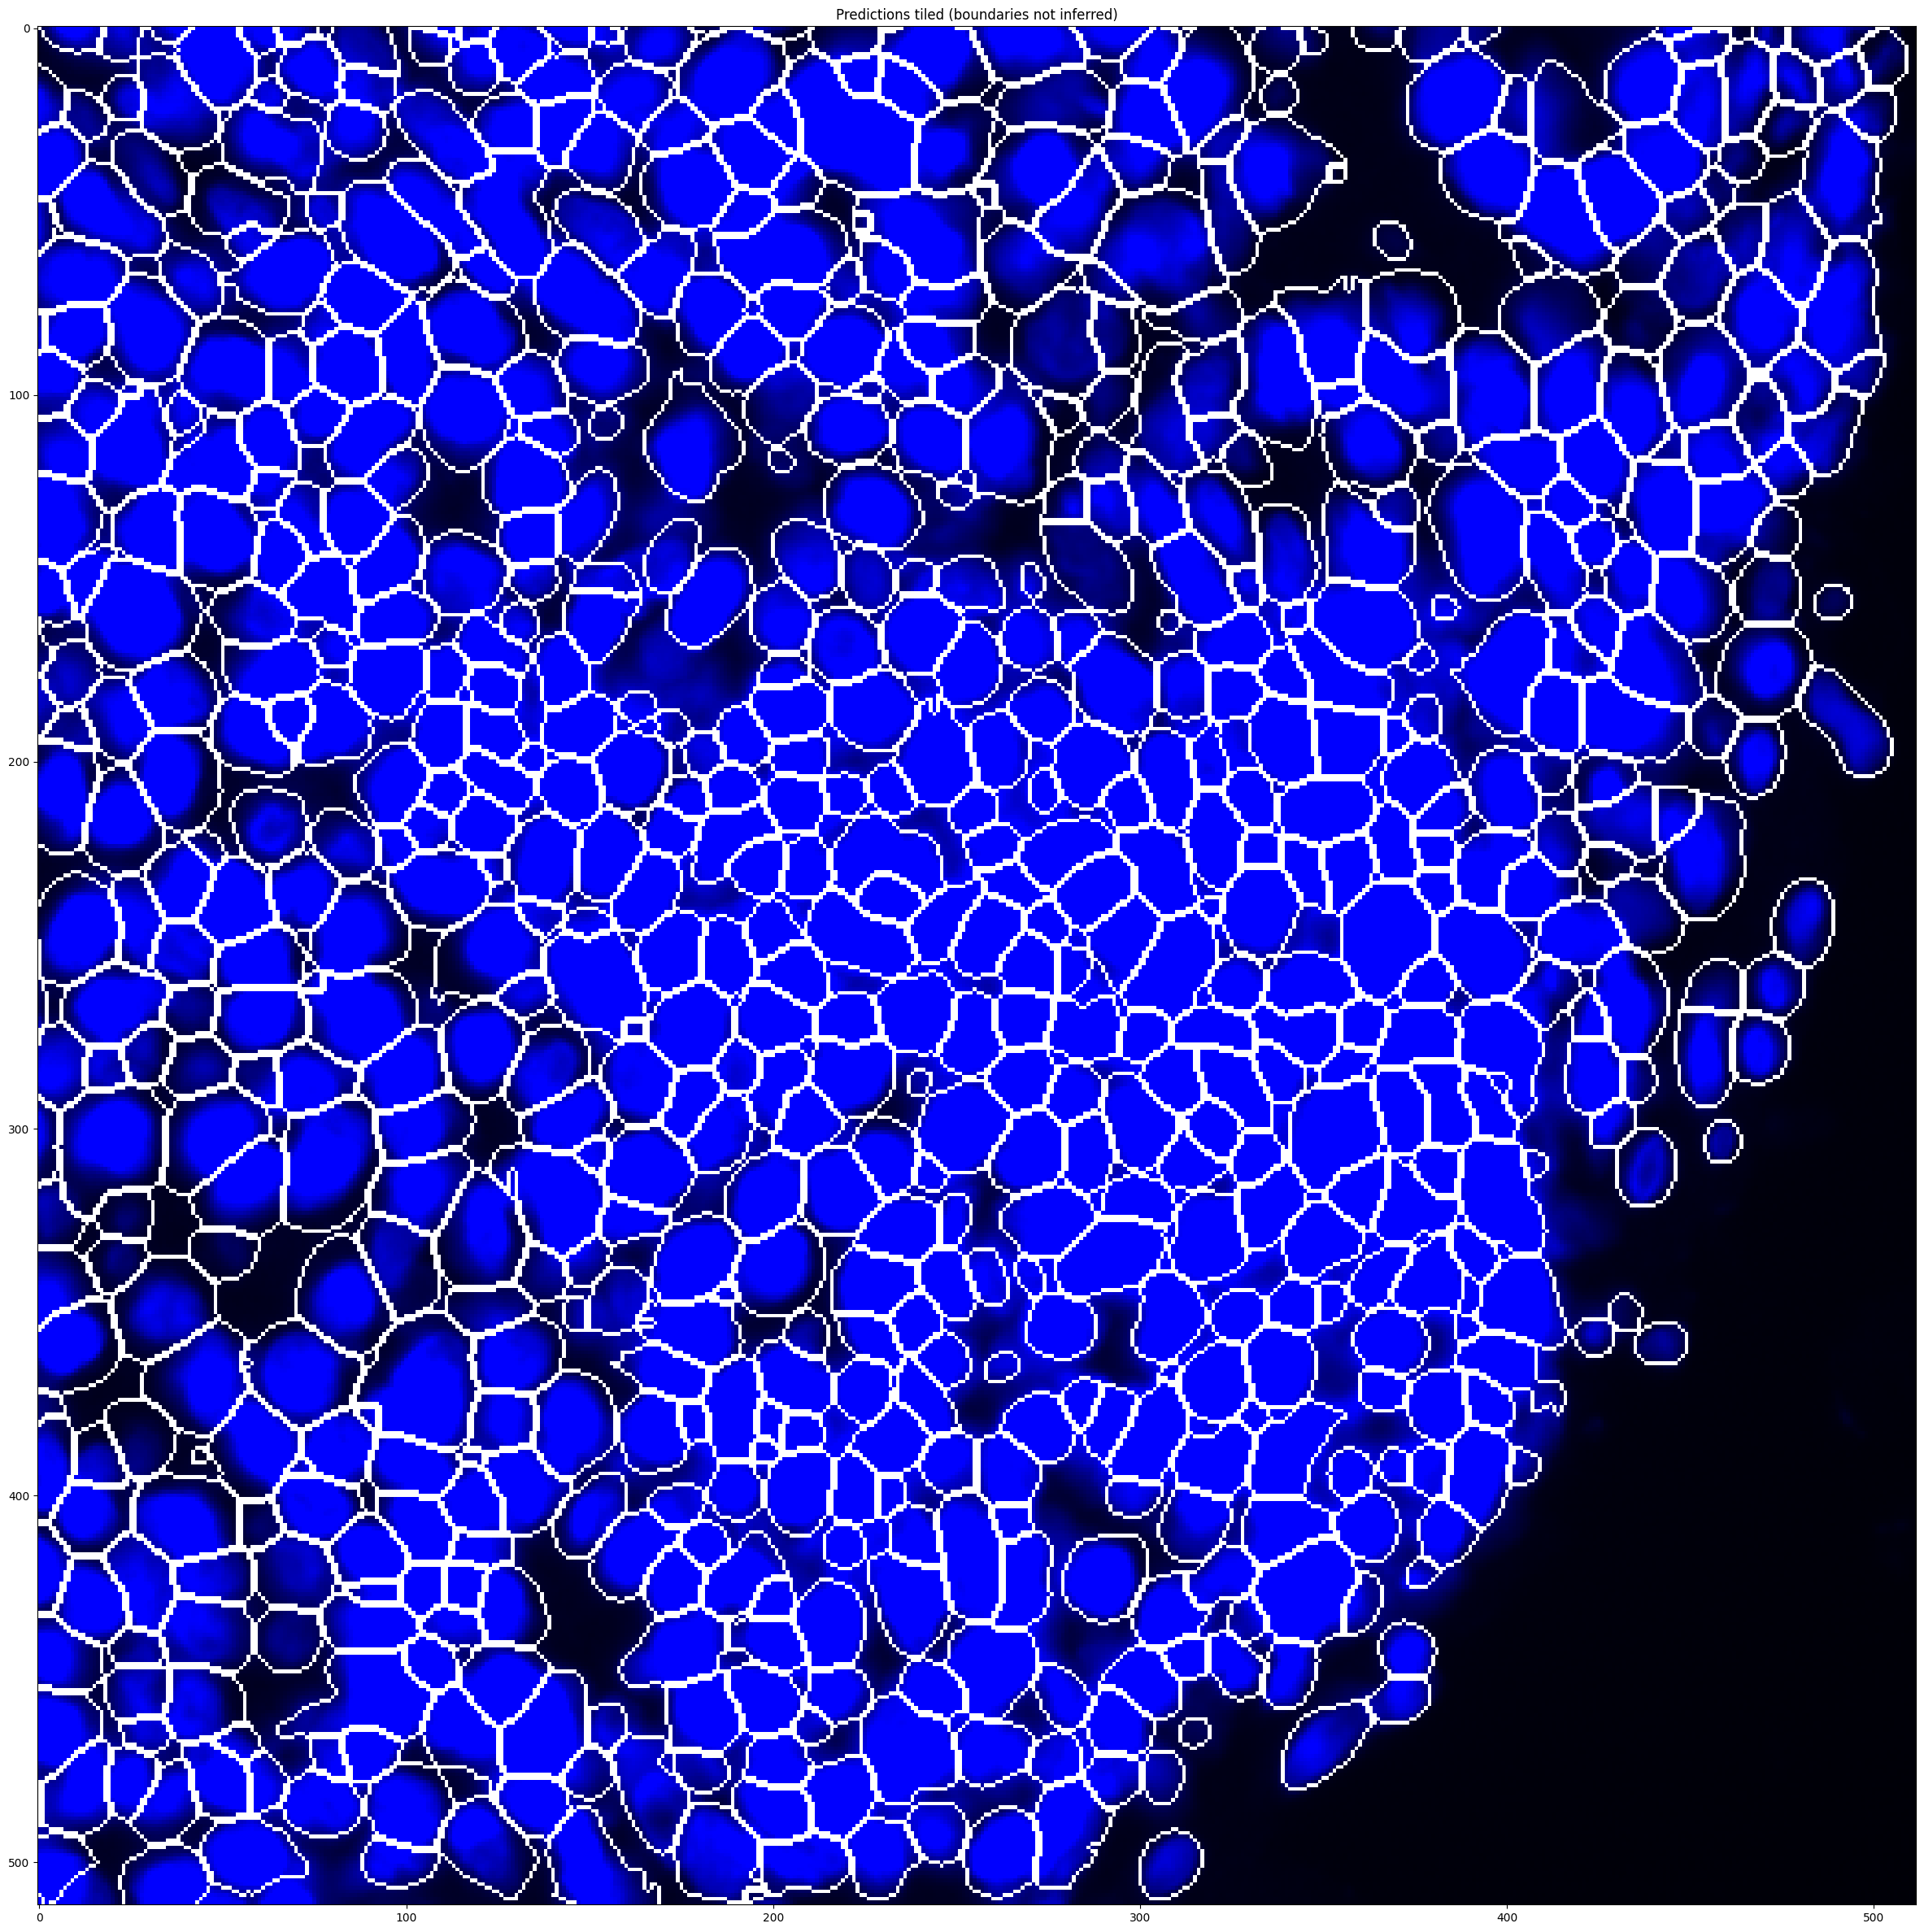

In [45]:
# select index for displaying
idx = 0

# plot the data
fig, ax = plt.subplots(1 ,figsize=(30, 30))

# ax[0].imshow(overlay_data[idx, 6000:6512, 2500:3012, ...])
ax.imshow(overlay_data_tile_pipeline_no_gaps[0, 6000:6512, 2500:3012,...])
# ax[1].imshow(overlay_data_tile_pipeline_gaps[idx, ...])

# ax[0].set_title('Predictions whole')
ax.set_title('Predictions tiled (boundaries not inferred)')
# ax[1].set_title('Predictions tiled (boundaries removed)')

plt.show()

In [40]:
# areas_whole = np.asarray([np.sum(segmentation_predictions_whole_gaps[0,:,:,:] == l) for l in np.unique(segmentation_predictions_whole_gaps[0,:,:,:])][1:])

In [41]:
# areas_tiled_gaps = np.asarray([np.sum(segmentation_predictions_whole_gaps[1,:,:,:] == l) for l in np.unique(segmentation_predictions_whole_gaps[1,:,:,:])][1:])

In [42]:
# (areas_tiled_gaps[areas_tiled_gaps > 50]).shape

In [43]:
# (areas_whole[areas_whole > 50]).shape

In [82]:
def save_model_output_wrapper(segmentation_mask, output_dir, feature_name, compartment):
    save_model_output(segmentation_mask, output_dir=output_dir, feature_name=feature_name)
    # rename saved mask tiff
    old_name = feature_name + '_feature_0_frame_000.tif'
    
    if compartment == "both":
        suffix = ["nuclear", "whole_cell"]
    elif compartment == "whole-cell":
        suffix = "whole_cell"
    elif compartment == "nuclear":
        suffix = "nuclear"
        
    new_name = feature_name + '_' + suffix + '.tiff'
    
    old_name_path = os.path.join(output_dir, old_name)
    new_name_path =  os.path.join(output_dir, new_name)
    os.rename(old_name_path,new_name_path)

In [80]:
save_model_output_wrapper(segmentation_predictions_whole_gaps, output_dir=deepcell_output_dir, feature_name=fovs[0],compartment="whole-cell")

Saved 1 frames to ../data/external/dataset_1/segmentation/deepcell_output


In [81]:
# save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir)
segmentation_utils.save_segmentation_labels(
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=deepcell_visualization_dir,
    fovs=io_utils.remove_file_extensions(fovs),
    channels=None
)

### Export array as tiff per fov and look what the above function does

In [ ]:
## save segmentation results to tiff with _whole_cell.tiff suffix

### Afterwards, we can generate expression matrices from the labeling + imaging data

In [83]:
# set to True to add nuclear cell properties to the expression matrix
nuclear_counts = False

# set to True to bypass expensive cell property calculations
# only cell label, size, and centroid will be extracted if True
fast_extraction = True

For a full list of features extracted, please refer to the cell table section of: https://ark-analysis.readthedocs.io/en/latest/_rtd/data_types.html

In [84]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder=None,
                                              fovs=fovs,
                                              batch_size=5,
                                              nuclear_counts=nuclear_counts,
                                              fast_extraction=fast_extraction)

extracting data from ATAPOX166R-3


In [85]:
# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(os.path.join(cell_table_dir, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(cell_table_dir, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)

## Perform CellDIVE specific QC

### DAPI divergence and cell size

In [86]:
cell_table_size_normalized_qc = cell_table_size_normalized.loc[cell_table_size_normalized["cell_size"] > 50,]
cell_table_size_normalized_qc = cell_table_size_normalized_qc.loc[abs(cell_table_size_normalized_qc["DAPI_INIT"] - cell_table_size_normalized_qc["DAPI_FINAL"])/cell_table_size_normalized_qc["DAPI_INIT"] <= 0.5, ]

In [88]:
list_arcsinh_transformed_qc = []
# cell_table_arcsinh_transformed_qc = cell_table_arcsinh_transformed_qc.loc[[False for j in range(cell_table_arcsinh_transformed_qc.shape[0])], ]

for j in fovs:
    array_mask = np.isin(np.array(cell_table_arcsinh_transformed.loc[cell_table_arcsinh_transformed["fov"] == j, "label"]),  np.array(cell_table_size_normalized_qc.loc[cell_table_size_normalized_qc["fov"] == j, "label"]))
    
    df = pd.DataFrame.copy(cell_table_arcsinh_transformed)
    df = pd.DataFrame(df.loc[df["fov"] == j,].loc[array_mask,])
    list_arcsinh_transformed_qc.append(df,) 

cell_table_arcsinh_transformed_qc = pd.concat(list_arcsinh_transformed_qc)

In [89]:
all(cell_table_arcsinh_transformed_qc["label"] == cell_table_size_normalized_qc["label"])

True

In [90]:
compression = None
cell_table_size_normalized_qc.to_csv(os.path.join(cell_table_dir_qc, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed_qc.to_csv(os.path.join(cell_table_dir_qc, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)

## Create OME-TIFF with cell mask label

In [55]:
def lnk_mask_to_tiff(imagefilepath, maskspath):
    tiff_files_paths = [ str(j) for j in list(pathlib.Path(imagefilepath).glob("*"))]
    for tiff_files_path in tiff_files_paths:
        fov_name = os.path.basename(tiff_files_path)
        mask_tiff_whole_cell = fov_name + '_whole_cell.tiff'
        mask_single_tiff_whole_cell = os.path.join(tiff_files_path, 'WholeCellSeg.tiff')

        cmdstring = 'ln -fs ' + os.path.join('../../segmentation',os.path.basename(deepcell_output_dir), mask_tiff_whole_cell) + ' ' + mask_single_tiff_whole_cell
        print(cmdstring)
        os.system(cmdstring)
    # return ome_tiff_files_path

In [211]:
def get_fname_woext(filepath):

    # create empty string
    real_extension = ''

    # get all part of the file extension
    sufs = Path(filepath).suffixes
    for s in sufs:
        real_extension = real_extension + s

    # remover real extension from filepath
    filepath_woext = filepath.replace(real_extension, '')

    return filepath_woext

def convert_to_pyramid_ometiff(tiff_dir, imagefilepath,
                       bftoolsdir='/opt/bftools',
                       verbose=True):

    # check if path exits
    if not os.path.exists(bftoolsdir):
        print('No bftools dirctory found. Nothing will be converted')
        file_ometiff = None

    if os.path.exists(bftoolsdir):
        # set working dir
        # os.chdir(bftoolsdir)

        load_utils.fov_to_ome(tiff_dir, imagefilepath)
        
        ome_tiff_files_path = [ str(j) for j in list(set(pathlib.Path(imagefilepath).glob("*")) - set(pathlib.Path(imagefilepath).glob("*.pyramid.*")))] #list(pathlib.Path(imagefilepath).glob("*.ome.[tif tiff]*"))
        print(ome_tiff_files_path)
        for ome_tiff_file_path in ome_tiff_files_path:
            # get the imagefile path without extension
            imagefilepath_woext = get_fname_woext(ome_tiff_file_path)

            # create imagefile path for OME.TIFF
            file_ometiff = imagefilepath_woext + '.pyramid.ome.tiff'

            # create cmdstring for non-CZIs- mind the spaces !!!
            cmdstring = bftoolsdir + '/bfconvert -noflat -pyramid-resolutions 4 -pyramid-scale 2' + ' "' + ome_tiff_file_path + '" "' + file_ometiff + '"'

            if verbose:
                print('Original ImageFile : ', imagefilepath_woext)
                print('ImageFile OME.TIFF : ', file_ometiff)
                print('Use CMD : ', cmdstring)

            # run the bfconvert tool with the specified parameters
            os.system(cmdstring)
            print(imagefilepath_woext + ' done.')

In [91]:
# convert_to_pyramid_ometiff(ome_tiff_out_dir)